In [137]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import math
import copy

In [138]:
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.models as models

## Image to Tensor Conversions

In [134]:
imsize = 256

def file_to_tensor(file_path):
    image = Image.open(file_path)
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def image_to_tensor(image):
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def tensor_to_image(tensor):
    img = transforms.ToPILImage()(tensor.clone().cpu().squeeze(0))
    return img

In [201]:
set_folder = "Set7"

content = file_to_tensor("UpdatedSets/"+set_folder+"/content.jpg")
style = file_to_tensor("UpdatedSets/"+set_folder+"/style.png")

In [202]:
if content.size() != style.size():
    print("Please execute Processing the Data.ipynb on the dataset")

## Choosing the optimal model

In [142]:
device = torch.device("cuda")
vgg = models.vgg19_bn(pretrained=True).features.to(device).eval()

# Setting Up the Normalisation Layer for VGG

In [21]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1,1,1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1,1,1)
    
    def forward(self, img):
        return (img - self.mean)/self.std

# Setting Up the Content Loss - Simple MSE Loss

In [38]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(img, self.target)
        return img

# Setting Up the Style Loss - Using Gram Matrix

In [24]:
def convert_to_gram(img):
    b, f, h, w = img.size()
    reshp_img = img.view(b*f, w*h)
    gram = torch.mm(reshp_img, reshp_img.t()).div(b*f*w*h)
    return gram

In [53]:
class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = convert_to_gram(target).detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(convert_to_gram(img), self.target)
        return img

# Create the new model

In [203]:
content_layers = ['conv_2', 'conv_5']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_7']


def get_new_model(vgg19, content_image, style_image):
    
    global content_layers
    global style_layers
    content_modules = []
    style_modules = []

    vgg = copy.deepcopy(vgg19)
    normalisation = Normalization().to(device)
    model = nn.Sequential(normalisation)
    i = 0

    for layer in vgg:
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_'+str(i)

        elif isinstance(layer, nn.ReLU):
            name = 'relu_'+str(i)

        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_'+str(i)

        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_'+str(i)

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_image).detach()
            content_l = ContentLoss(target)
            model.add_module('content_layer_'+str(i), content_l)
            content_modules.append(content_l)
        
        if name in style_layers:
            target = model(style_image).detach()
            style_l = StyleLoss(target)
            model.add_module('style_layer_'+str(i), style_l)
            style_modules.append(style_l)
        
    for i in range(len(model)-1, 0, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i+1]
    return model, content_modules, style_modules

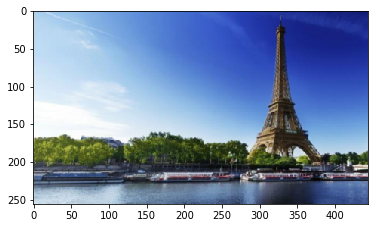

In [204]:
use_content = True
input_img = None

if use_content is True:
    # For using the content image
    input_img = tensor_to_image(content)
else:
    # For using random noise as input
    input_img = tensor_to_image(torch.randn(content.data.size(), device=device))

plt.imshow(input_img)

# Training the model

In [205]:
def style_transfer(vgg, content_img, style_img, input_img, iters=10, style_w=1000000, content_w=1):
    
    input_img = image_to_tensor(input_img)
    model, con_layers, st_layers = get_new_model(vgg, content_img, style_img)
    optimiser = torch.optim.LBFGS([input_img.requires_grad_()])
    
    for i in range(iters):
        
        def closure():
            input_img.data.clamp_(0, 1)
            model(input_img)
            style_val = 0
            content_val = 0
            
            optimiser.zero_grad()

            for sc in st_layers:
                style_val += sc.loss
            for cc in con_layers:
                content_val += cc.loss

            net_loss = style_w*style_val + content_w*content_val
            net_loss.backward()
            print('Iteration {}: '.format(i+1), 'Style Loss = {:4f} '.format(style_val),
              'Content Loss = {:4f} '.format(content_val))
            return net_loss
            
        optimiser.step(closure)

    input_img.data.clamp_(0, 1)
    final_img = tensor_to_image(input_img)
    plt.imshow(final_img)
    return final_img

In [ ]:
output = style_transfer(vgg, content, style, input_img, iters=20, style_w=1000000, content_w=1)
output.save("UpdatedSets/"+set_folder+"/output.png")

Iteration 1:  Style Loss = 0.000022  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000022  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000021  Content Loss = 0.000880 
Iteration 1:  Style Loss = 0.000064  Content Loss = 0.692091 
Iteration 1:  Style Loss = 0.000009  Content Loss = 0.101413 
Iteration 1:  Style Loss = 0.000005  Content Loss = 0.139715 
Iteration 1:  Style Loss = 0.000005  Content Loss = 0.271095 
Iteration 1:  Style Loss = 0.000002  Content Loss = 0.177798 
Iteration 1:  Style Loss = 0.000002  Content Loss = 0.192099 
Iteration 1:  Style Loss = 0.000001  Content Loss = 0.217361 
Iteration 1:  Style Loss = 0.000001  Content Loss = 0.224600 
Iteration 1:  Style Loss = 0.000000  Content Loss = 0.241207 
Iteration 1:  Style Loss = 0.000000  Content Loss = 0.237815 
Iteration 1:  Style Loss = 0.000000  Content Loss = 0.238462 
Iteration 1:  Style Loss = 0.000000  Content Loss = 0.246151 
Iteration 1:  Style Loss = 0.000000  Content Loss = 0.251927 
Iteratio

Iteration 7:  Style Loss = 0.000000  Content Loss = 0.219894 
Iteration 7:  Style Loss = 0.000000  Content Loss = 0.220033 
Iteration 7:  Style Loss = 0.000000  Content Loss = 0.219832 
Iteration 7:  Style Loss = 0.000000  Content Loss = 0.219453 
Iteration 7:  Style Loss = 0.000000  Content Loss = 0.218755 
Iteration 7:  Style Loss = 0.000000  Content Loss = 0.220731 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.219062 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.227125 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.222020 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.229059 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.225808 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.229112 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.226121 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.226736 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.229669 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.226761 
Iteratio